<a href="https://colab.research.google.com/github/Kolo-Naukowe-Axion/QC1/blob/dnn/classical_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Banknote Authentication classical ML**

**Overview:** This project implements a binary classification model using PyTorch to detect counterfeit banknotes based on four mathematical parameters extracted from images:
*   Variance
*   Skewness
*   Kurtosis
*   Entropy

**Dataset Insights:** The solution uses the *UCI Banknote Authentication Data Set* (1372 records). Prior Exploratory Data Analysis (EDA) highlighted two key factors:

**Balance:** The dataset is well-balanced (55% authentic / 45% counterfeit).

**Separability:** There is a clear linear separation between classes.

his strong linear separability allowed the neural network, combined with StandardScaler normalization, to easily define decision boundaries and achieve near-perfect accuracy on the test set. For benchmarking purposes, a Logistic Regression model was also trained, reaching ~98% accuracy, which further corroborates the high quality and distinct separation of the dataset features.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Data loading
# Note: Ensure ucimlrepo is installed: !pip install ucimlrepo
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


### **Data Loading & Preprocessing:**
 We fetch the data directly from the UCI repository, convert it to NumPy arrays, and split it into training (80%) and testing (20%) sets.

In [5]:
# Fetch data
banknote_authentication = fetch_ucirepo(id=267)

# Extract features and targets
X_raw = banknote_authentication.data.features
y_raw = banknote_authentication.data.targets

# Convert to numpy
X = X_raw.values
y = y_raw.values.ravel()

# Split data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Crucial for Neural Networks optimization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

print(f"Training Tensor Shape: {X_train_tensor.shape}") # 4 different parameters for one banknote: variance	skewness	kurtosis	entropy
print(f"Testing Tensor Shape: {X_test_tensor.shape}")

Training Tensor Shape: torch.Size([1097, 4])
Testing Tensor Shape: torch.Size([275, 4])


### **Model Architecture:**
We define a Feed-Forward Neural Network (BanknoteDNN) with the following structure:
* Input Layer: 4 Neurons (corresponding to the 4 features).
* Hidden Layers: 64 -> 32 -> 16 neurons with $ReLU$ activation to introduce non-linearity.
* Dropout: Applied after the first layer (rate=0.2) to prevent overfitting.
* Output Layer: 1 Neuron with $Sigmoid$ activation, outputting the probability of the banknote being authentic.

In [6]:
class BanknoteDNN(nn.Module):
    def __init__(self):
        super(BanknoteDNN, self).__init__()
        self.layer1 = nn.Linear(4, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        # Sigmoid bounds output between 0 and 1
        x = self.sigmoid(self.output(x))
        return x

model = BanknoteDNN().to(device)

### **Training Loop:**

* Loss Function: Binary Cross Entropy Loss (BCELoss), suitable for binary classification.
* Optimizer: Adam (lr=0.001).
* Epochs: 100.

In [7]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
print("\nStarting training...")

for epoch in range(epochs):
  # Training Phase
    model.train()

    outputs = model(X_train_tensor)

    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation Phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        # Convert probabilities to binary class (threshold 0.5)
        predicted = (test_outputs > 0.5).float()
        correct = (predicted == y_test_tensor).float().sum()
        accuracy = correct / y_test_tensor.shape[0]

    if epoch%10==0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f} | Test Acc: {accuracy:.4f}")


Starting training...
Epoch 1/100 | Train Loss: 0.6930 | Test Loss: 0.6884 | Test Acc: 0.4618
Epoch 11/100 | Train Loss: 0.6640 | Test Loss: 0.6596 | Test Acc: 0.9236
Epoch 21/100 | Train Loss: 0.6193 | Test Loss: 0.6152 | Test Acc: 0.8945
Epoch 31/100 | Train Loss: 0.5523 | Test Loss: 0.5492 | Test Acc: 0.8982
Epoch 41/100 | Train Loss: 0.4588 | Test Loss: 0.4610 | Test Acc: 0.9055
Epoch 51/100 | Train Loss: 0.3586 | Test Loss: 0.3616 | Test Acc: 0.9164
Epoch 61/100 | Train Loss: 0.2608 | Test Loss: 0.2629 | Test Acc: 0.9309
Epoch 71/100 | Train Loss: 0.1790 | Test Loss: 0.1784 | Test Acc: 0.9636
Epoch 81/100 | Train Loss: 0.1250 | Test Loss: 0.1188 | Test Acc: 0.9745
Epoch 91/100 | Train Loss: 0.0865 | Test Loss: 0.0835 | Test Acc: 0.9782


**Baseline Comparison:** Logistic Regression to confirm the dataset's high separability. We train a simple Logistic Regression model. A high accuracy here confirms that the features are very distinct and a complex model (while effective) might be overkill.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
print(f"Simple model accuracy: {accuracy_score(y_test, preds)*100:.2f}%")

Simple model accuracy: 97.82%


# Confusion Matrix

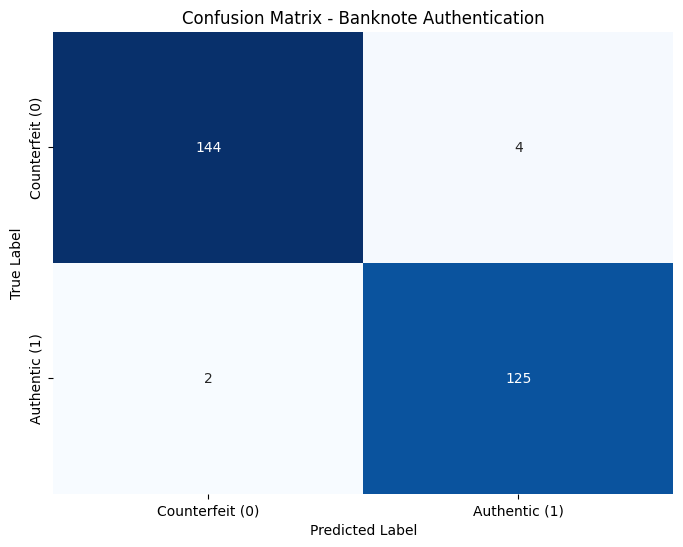

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode (disables dropout layers)
model.eval()

# Generate predictions on the test set
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    # Convert probabilities to binary classes (0 or 1) using a 0.5 threshold
    # > 0.5 becomes 1 (Authentic), <= 0.5 becomes 0 (Counterfeit)
    y_pred_classes = (y_pred_logits > 0.5).float()

cm = confusion_matrix(y_test_tensor, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Counterfeit (0)', 'Authentic (1)'],
            yticklabels=['Counterfeit (0)', 'Authentic (1)'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Banknote Authentication')
plt.show()